<a href="https://colab.research.google.com/github/i-amgeek/fastai2/blob/master/deconv_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, I have experimented by combining [deconvolution](https://github.com/yechengxi/deconvolution/) with other techniques used for creating SOTA models like `mish`, `ranger`, `xresnet`, `MaxBlurPool` etc. **Outputs of cells contain head-on comparison of results with deconv and without deconv**.


* In most runs, deconvolution have showed good improvements.

* Most improvement was when I used deconv with ReLU and SGD. As I started implementing it with better techniques like Mish and Ranger, improvements decreased.

* Every epoch with deconv took double time than without it. Although, I think, it can be improved using JIT and if im2col is implemented in C in `aten` library with other algorithims like [Winograd](https://blog.usejournal.com/understanding-winograd-fast-convolution-a75458744ff).

**To run this notebook, install fastai2 by recursive cloning from [my fork](https://github.com/i-amgeek/fastai2) .**

## Import modules and initialize functions

MaxBlurPool improved training speed as shown in this [paper](https://arxiv.org/pdf/1904.11486).

In [0]:
from kornia.contrib import MaxBlurPool2d

# Adopted from 
# https://discuss.pytorch.org/t/how-can-i-replace-an-intermediate-layer-in-a-pre-trained-network/3586/7

def convert_MP_to_blurMP(model, layer_type_old):
    conversion_count = 0
    for name, module in reversed(model._modules.items()):
        if len(list(module.children())) > 0:
            # recurse
            model._modules[name] = convert_MP_to_blurMP(module, layer_type_old)

        if type(module) == layer_type_old:
            layer_old = module
            layer_new = MaxBlurPool2d(3, True)
            model._modules[name] = layer_new

    return model

In [0]:
import torch
from torch import nn as nn
from torch.nn import functional as F
torch.cuda.set_device(0)

__all__ = ['swish_jit', 'SwishJit', 'mish_jit', 'MishJit']
           #'hard_swish_jit', 'HardSwishJit', 'hard_sigmoid_jit', 'HardSigmoidJit']


@torch.jit.script
def swish_jit_fwd(x):
    return x.mul(torch.sigmoid(x))


@torch.jit.script
def swish_jit_bwd(x, grad_output):
    x_sigmoid = torch.sigmoid(x)
    return grad_output * (x_sigmoid * (1 + x * (1 - x_sigmoid)))



class SwishJitAutoFn(torch.autograd.Function):
    """ torch.jit.script optimised Swish
    Inspired by conversation btw Jeremy Howard & Adam Pazske
    https://twitter.com/jeremyphoward/status/1188251041835315200
    """
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return swish_jit_fwd(x)

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        return swish_jit_bwd(x, grad_output)


def swish_jit(x, inplace=False):
    # inplace ignored
    return SwishJitAutoFn.apply(x)


class SwishJit(nn.Module):
    def __init__(self, inplace: bool = False):
        super(SwishJit, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return SwishJitAutoFn.apply(x)


@torch.jit.script
def mish_jit_fwd(x):
    return x.mul(torch.tanh(F.softplus(x)))


@torch.jit.script
def mish_jit_bwd(x, grad_output):
    x_sigmoid = torch.sigmoid(x)
    x_tanh_sp = F.softplus(x).tanh()
    return grad_output.mul(x_tanh_sp + x * x_sigmoid * (1 - x_tanh_sp * x_tanh_sp))


class MishJitAutoFn(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return mish_jit_fwd(x)

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_tensors[0]
        return mish_jit_bwd(x, grad_output)


def mish_jit(x, inplace=False):
    # inplace ignored
    return MishJitAutoFn.apply(x)


class MishJit(nn.Module):
    def __init__(self, inplace: bool = False):
        super(MishJit, self).__init__()
        self.inplace = inplace

    def forward(self, x):
        return MishJitAutoFn.apply(x)


In [0]:
def mini_net(n_out=1000, pretrained=False,deconv=True, **kwargs):
    block=SEResNeXtBlock
    expansion=1
    layers=[1,1,1,1] # [2,2,2,2,1,1] xse_resnext18_deep
    groups=64        # 32 
    reduction=8      # 16
    return XResNet(block, expansion, layers, n_out=n_out, groups=groups, reduction=reduction, deconv=deconv, **kwargs)

globals()['mini_net'] = mini_net

In [0]:
import fastai2
fastai2.__file__

'/root/anaconda3/lib/python3.7/site-packages/fastai2/__init__.py'

In [0]:
import PIL # hack to re-instate PILLOW_VERSION (thanks pillow 7 :o)
PIL.PILLOW_VERSION = PIL.__version__

from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *
from fastai2.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastai2.vision.models.xresnet import *
from fastai2.callback.mixup import *
from fastscript import *

torch.backends.cudnn.benchmark = True
fastprogress.MAX_COLS = 80

In [0]:
def get_dls(size, woof, bs, sh=0., workers=None):
    if size<=224: path = URLs.IMAGEWOOF_320 if woof else URLs.IMAGENETTE_320
    else        : path = URLs.IMAGEWOOF     if woof else URLs.IMAGENETTE
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    # Resize seems to give slightly better accuracy than RandomResizedCrop
    resize_ftm = Resize(size) # RandomResizedCrop(size, min_scale=0.35)
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=[resize_ftm, FlipItem(0.5)],
                       batch_tfms=RandomErasing(p=0.3, max_count=3, sh=sh) if sh else None)
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=0)

In [0]:
@call_parse
def main(
    gpu:   Param("GPU to run on", int)=None,
    woof:  Param("Use imagewoof (otherwise imagenette)", int)=1,
    lr:    Param("Learning rate", float)=1e-2,
    size:  Param("Size (px: 128,192,256)", int)=128,
    sqrmom:Param("sqr_mom", float)=0.99,
    mom:   Param("Momentum", float)=0.9,
    eps:   Param("epsilon", float)=1e-6,
    epochs:Param("Number of epochs", int)=5,
    bs:    Param("Batch size", int)=32,
    mixup: Param("Mixup", float)=0.,
    opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='ranger',
    arch:  Param("Architecture", str)='xresnet18',
    sh:    Param("Random erase max proportion", float)=0.,
    sa:    Param("Self-attention", int)=0,
    sym:   Param("Symmetry for self-attention", int)=0,
    beta:  Param("SAdam softplus beta", float)=0.,
    act_fn:Param("Activation function", str)='MishJit',
    fp16:  Param("Use mixed precision training", int)=0,
    pool:  Param("Pooling method", str)='AvgPool',
    dump:  Param("Print model; don't train", int)=0,
    runs:  Param("Number of times to repeat training", int)=1,
    meta:  Param("Metadata (ignored)", str)='',
    wd:    Param("Weight decay", float)=1e-2,
    deconv:Param("Deconv", bool)=False,
    blur:  Param("MaxBlurPool", bool)=False
):
    "Training of Imagenette."

    #gpu = setup_distrib(gpu)
    if gpu is not None: torch.cuda.set_device(gpu)
    if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=sqrmom)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
    elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

    dls = get_dls(size, woof, bs, sh=sh)
    if not gpu: 
        print(f'epochs: {epochs}; lr: {lr}; size: {size}; sqrmom: {sqrmom}; mom: {mom}; eps: {eps}')
        print(f'fp16: {fp16}; arch: {arch}; wd: {wd}; act_fn: {act_fn}; bs: {bs}')
        print(f'pool: {pool}; woof: {woof}; sh:{sh}')
        
    m,act_fn,pool = [globals()[o] for o in (arch,act_fn,pool)]
    
    for run in range(runs):
        print(f'Run: {run}')
        for deconv in [True, False]:
            print('\t\t\t DECONV' if deconv else '\t\t\t Without DECONV')
            model = m(n_out=10, act_cls=act_fn, sa=sa, sym=sym, pool=pool, deconv=deconv)
            if blur:
                model = convert_MP_to_blurMP(model, nn.MaxPool2d)
            learn = Learner(dls, model, opt_func=opt_func, \
                    metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
            if dump: 
                print(learn.model); exit()
            if fp16: learn = learn.to_fp16()
            cbs = MixUp(mixup) if mixup else []
            learn.fit_flat_cos(epochs, lr, wd=wd, cbs=cbs)
        
    return learn

## Comparison on Imagenette Dataset

In [0]:
size = 128
woof = 0
bs = 32
sh = 0.
dls = get_dls(size, woof, bs, sh=sh)
m, act, pool = globals()['xresnet18'], globals()['MishJit'], globals()['AvgPool']

opt_func = partial(ranger, mom=0.9, sqr_mom=0.99, eps=1e-6, beta=0)
learn = Learner(dls, m(n_out=10, act_cls=act, sa=0, sym=0, pool=pool, deconv=True), opt_func=opt_func, \
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addmm is deprecated:
	addmm(Number beta, Tensor input, Number alpha, Tensor mat1, Tensor mat2, *, Tensor out)
Consider using one of the following signatures instead:
	addmm(Tensor input, Tensor mat1, Tensor mat2, *, Number beta, Number alpha, Tensor out)


SuggestedLRs(lr_min=0.00036307806149125097, lr_steep=0.0014454397605732083)

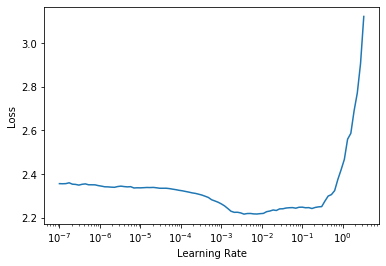

In [0]:
learn.lr_find()

I will use `lr` somewhere between `lr_min` and `lr_steep` - 0.0008

In [0]:
del learn
import gc; gc.collect()

33929

In [0]:
learn = main(runs=3, lr=0.0008, arch='xresnet18', epochs=5, opt='sgd', act_fn = 'Mish', woof=0, blur=False)

epochs: 5; lr: 0.0008; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet18; wd: 0.01; act_fn: Mish; bs: 32
pool: AvgPool; woof: 0; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.729565,1.584505,0.556178,0.916178,01:36
1,1.523572,1.431844,0.628790,0.931720,01:37
2,1.396795,1.378073,0.660127,0.942166,01:37
3,1.303251,1.338582,0.686624,0.949299,01:37
4,1.270989,1.310148,0.705732,0.952866,01:37


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.841771,1.812542,0.436688,0.880000,00:47
1,1.695737,1.665762,0.545732,0.906242,00:47
2,1.604664,1.578199,0.577834,0.921783,00:47
3,1.534407,1.523221,0.593376,0.933503,00:47
4,1.476672,1.478830,0.616815,0.937580,00:47


Run: 1
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.763830,1.606522,0.543185,0.910064,01:36
1,1.541716,1.452071,0.623439,0.932994,01:37
2,1.395911,1.379467,0.662930,0.939873,01:37
3,1.307429,1.342774,0.690446,0.948280,01:37
4,1.279097,1.308850,0.707261,0.952102,01:37


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.875949,1.831929,0.444076,0.873885,00:47
1,1.701992,1.696453,0.513121,0.901146,00:47
2,1.603450,1.593356,0.561019,0.919490,00:47
3,1.556298,1.515756,0.609427,0.931465,00:47
4,1.509566,1.474293,0.621401,0.942420,00:47


Run: 2
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.756230,1.578078,0.556943,0.911592,01:36
1,1.512965,1.429971,0.633121,0.937070,01:37
2,1.397188,1.371289,0.674395,0.944713,01:37
3,1.325806,1.352979,0.687134,0.949299,01:37
4,1.276160,1.324359,0.693758,0.951338,01:37


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.875084,1.851118,0.432611,0.857580,00:47
1,1.720383,1.689013,0.516433,0.904968,00:47
2,1.620474,1.588787,0.557962,0.920255,00:47
3,1.563302,1.524466,0.586242,0.933758,00:47
4,1.513279,1.484640,0.609936,0.937070,00:47


In [0]:
lr = 0.0008
arch='mini_net'
learn = main(runs=5, lr=lr, arch=arch, wd=0.0001, woof=0, epochs=5, blur=True)

epochs: 5; lr: 0.0008; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: mini_net; wd: 0.0001; act_fn: MishJit; bs: 32
pool: AvgPool; woof: 0; sh:0.0
Run: 0
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.370374,1.257673,0.716433,0.958981,01:43
1,1.170298,1.226426,0.735541,0.965350,01:38
2,1.113066,1.182526,0.756178,0.969682,01:38
3,1.012197,1.108844,0.802803,0.978599,01:39
4,0.902036,1.057294,0.826242,0.975796,01:39


/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


			Without DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.579904,1.467684,0.617325,0.937325,00:50
1,1.321677,1.313811,0.679745,0.951338,00:49
2,1.229187,1.229775,0.712102,0.960510,00:50
3,1.134932,1.208459,0.714904,0.965605,00:50
4,1.013008,1.045467,0.793121,0.973503,00:50


Run: 1
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.343338,1.255494,0.721529,0.952102,01:38
1,1.183698,1.163518,0.758981,0.966369,01:39
2,1.096381,1.128443,0.784459,0.971720,01:39
3,1.012812,1.105600,0.797962,0.972229,01:39
4,0.878025,1.049604,0.825223,0.980127,01:39


			Without DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.610448,1.480859,0.615541,0.928153,00:50
1,1.343885,1.282684,0.687134,0.954395,00:50
2,1.211148,1.224869,0.707771,0.964331,00:50
3,1.110164,1.120817,0.762803,0.971210,00:50
4,1.002918,1.048802,0.792102,0.975287,00:50


Run: 2
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.351749,1.226477,0.727389,0.956688,01:38
1,1.181840,1.204843,0.751847,0.957707,01:39
2,1.078793,1.136474,0.780382,0.970701,01:39
3,1.009524,1.130328,0.789554,0.971210,01:39
4,0.894654,1.040012,0.819873,0.978344,01:39


			Without DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.597694,1.525868,0.593121,0.935032,00:50
1,1.355321,1.330642,0.675414,0.951338,00:50
2,1.215212,1.215372,0.722038,0.961529,00:50
3,1.119929,1.158857,0.741147,0.967389,00:50
4,0.991758,1.045556,0.791338,0.975541,00:50


Run: 3
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.352714,1.281401,0.714140,0.954650,01:38
1,1.188276,1.193166,0.753376,0.965605,01:39
2,1.098454,1.159369,0.787006,0.969427,01:40
3,1.015317,1.110914,0.805350,0.974013,01:40
4,0.890204,1.057745,0.824713,0.979108,01:39


			Without DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.567456,1.454579,0.618854,0.937070,00:50
1,1.340488,1.284122,0.694268,0.956178,00:50
2,1.195058,1.212665,0.722038,0.963312,00:50
3,1.117038,1.147652,0.749299,0.966115,00:50
4,1.002399,1.038908,0.793121,0.974013,00:50


Run: 4
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.331698,1.236331,0.728153,0.958726,01:39
1,1.176906,1.183722,0.763312,0.966115,01:39
2,1.086058,1.118095,0.797197,0.969427,01:39
3,1.015656,1.115145,0.807898,0.972994,01:39
4,0.896063,1.024494,0.831847,0.979363,01:39


			Without DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.581481,1.489838,0.606624,0.933758,00:50
1,1.336838,1.293241,0.689936,0.956178,00:50
2,1.185967,1.196432,0.731465,0.963822,00:50
3,1.147557,1.174922,0.739618,0.966624,00:50
4,1.008905,1.043918,0.788535,0.975541,00:50


In [0]:
learn = main(runs=2, lr=lr, arch='xresnet50', wd=0.0002, woof=0, epochs=5, blur=True)

epochs: 5; lr: 0.0008; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet50; wd: 0.0002; act_fn: MishJit; bs: 32
pool: AvgPool; woof: 0; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.566069,1.634002,0.582930,0.924076,02:05
1,1.325585,1.386784,0.672102,0.952102,02:07
2,1.224874,1.248818,0.721274,0.955414,02:06
3,1.130751,1.163908,0.737070,0.966369,02:07
4,0.981086,0.954295,0.819363,0.978854,02:07


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.499379,1.385681,0.642038,0.947261,01:05
1,1.269868,1.284974,0.685096,0.954395,01:05
2,1.159666,1.215163,0.718726,0.967134,01:05
3,1.086012,1.177339,0.727643,0.970446,01:05
4,0.920539,0.975823,0.821911,0.982930,01:05


Run: 1
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.624698,1.674228,0.555159,0.910573,02:07
1,1.349994,1.305387,0.683312,0.944204,02:07
2,1.231272,1.296888,0.688408,0.942166,02:07
3,1.134578,1.178458,0.736815,0.966879,02:07
4,0.950994,0.957555,0.817834,0.981656,02:07


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.522851,1.424098,0.630573,0.945223,01:05
1,1.277711,1.286479,0.684841,0.966115,01:05
2,1.182055,1.264717,0.703694,0.962038,01:05
3,1.110640,1.123935,0.753631,0.972229,01:05
4,0.931223,0.996253,0.819108,0.978344,01:05


## Comparison on ImageWoof Dataset

In [0]:
learn = main(runs=1, arch='xresnet18', epochs=20)

epochs: 20; lr: 0.01; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet18; wd: 0.01; act_fn: MishJit; bs: 32
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.126485,2.655085,0.217867,0.729448,01:32
1,1.906117,2.056211,0.370069,0.854670,01:33
2,1.715664,1.751881,0.488165,0.896920,01:33
3,1.554147,1.485931,0.589972,0.939934,01:33
4,1.430751,1.365463,0.637567,0.945279,01:34
5,1.356376,1.281747,0.679053,0.949351,01:34
6,1.287881,1.200325,0.712395,0.955968,01:34
7,1.195346,1.177968,0.716213,0.966149,01:34
8,1.143416,1.158346,0.721049,0.966913,01:34
9,1.091735,1.112769,0.750318,0.967167,01:33


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.033059,1.970296,0.306694,0.830237,00:45
1,1.850629,1.871534,0.375923,0.850853,00:45
2,1.668181,1.720360,0.453805,0.899720,00:45
3,1.574270,1.492040,0.572156,0.933571,00:45
4,1.444184,1.371611,0.623314,0.947315,00:45
5,1.353743,1.358958,0.629422,0.947569,00:45
6,1.263933,1.286520,0.666073,0.953932,00:46
7,1.192303,1.179975,0.714431,0.962840,00:46
8,1.167579,1.175913,0.728175,0.962840,00:45
9,1.104185,1.171258,0.718249,0.963095,00:45


In [0]:
learn = main(runs=1, arch='xresnet18', woof=1, epochs=5)

epochs: 5; lr: 0.01; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet18; wd: 0.01; act_fn: MishJit; bs: 32
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.118410,2.810780,0.261390,0.758972,01:31
1,1.943351,1.965958,0.380249,0.839654,01:32
2,1.695222,1.766248,0.473912,0.889030,01:32
3,1.595158,1.447325,0.594044,0.943497,01:32
4,1.284041,1.198919,0.706541,0.962840,01:33


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.023893,1.972633,0.326546,0.836854,00:45
1,1.827891,1.749221,0.430898,0.892339,00:45
2,1.656285,1.619626,0.491983,0.914991,00:46
3,1.518014,1.484798,0.560702,0.938152,00:45
4,1.282336,1.259454,0.683635,0.956223,00:45


In [0]:
arch='xresnet18'
learn = main(runs=2, arch=arch, epochs=5, opt='sgd', act_fn = 'inplace_relu')

epochs: 5; lr: 0.01; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet18; wd: 0.01; act_fn: inplace_relu; bs: 32
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.921049,2.027209,0.372359,0.834054,01:29
1,1.744858,1.728438,0.482566,0.899975,01:30
2,1.593387,1.612221,0.533724,0.915500,01:31
3,1.506956,1.499520,0.581318,0.933316,01:31
4,1.306175,1.381334,0.636040,0.942479,01:31


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.108419,2.212230,0.257572,0.735556,00:43
1,1.979659,2.091464,0.278697,0.804785,00:43
2,1.855821,2.305519,0.261899,0.761008,00:43
3,1.766648,2.389537,0.301349,0.750573,00:43
4,1.603161,1.583165,0.523288,0.926190,00:43


Run: 1
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.922206,2.010830,0.385849,0.847798,01:30
1,1.714483,1.780673,0.483075,0.894375,01:30
2,1.596038,1.666747,0.524561,0.907356,01:31
3,1.472262,1.520251,0.589972,0.922627,01:31
4,1.331738,1.400042,0.627895,0.945279,01:31


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.140923,2.211348,0.229320,0.755154,00:43
1,1.972090,2.030837,0.314329,0.822601,00:43
2,1.884897,2.039245,0.336727,0.844744,00:43
3,1.762735,2.068295,0.346908,0.812166,00:43
4,1.620445,1.615603,0.516925,0.916264,00:43


In [0]:
learn = main(runs=1, lr=0.0008, arch='xresnet18', epochs=5, opt='sgd', act_fn = 'Mish', woof=1, blur=True)

epochs: 5; lr: 0.0008; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet18; wd: 0.01; act_fn: Mish; bs: 32
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.073675,2.019893,0.315347,0.806821,01:33
1,1.939437,1.891710,0.396793,0.850598,01:34
2,1.810890,1.879162,0.431407,0.858997,01:34
3,1.721364,1.834330,0.462204,0.871469,01:34
4,1.640329,1.786612,0.480275,0.878341,01:34


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.158818,2.156596,0.233647,0.733011,00:46
1,2.122006,2.108923,0.259099,0.757190,00:46
2,2.071948,2.069324,0.279969,0.795113,00:46
3,2.023926,2.036589,0.293713,0.806567,00:46
4,2.002402,2.014189,0.318402,0.806058,00:46


In [0]:
learn = main(runs=2, lr=0.0008, arch='xresnet18', epochs=5, opt='ranger', act_fn = 'inplace_relu', blur=True)

epochs: 5; lr: 0.0008; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet18; wd: 0.01; act_fn: inplace_relu; bs: 32
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.006927,2.096415,0.356579,0.814966,01:33
1,1.842004,1.905671,0.425554,0.865615,01:33
2,1.692095,1.724472,0.495546,0.894630,01:32
3,1.571453,1.602531,0.540850,0.915500,01:32
4,1.428722,1.480094,0.588190,0.931789,01:33


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.015514,1.950760,0.337490,0.836345,00:45
1,1.816131,1.778233,0.420209,0.877577,00:45
2,1.688105,1.634967,0.498600,0.909646,00:45
3,1.550324,1.605282,0.511072,0.912955,00:45
4,1.391209,1.436654,0.594553,0.939425,00:45


Run: 1
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.991459,2.101458,0.348944,0.824892,01:31
1,1.823198,1.847709,0.446933,0.872996,01:32
2,1.696139,1.710647,0.496819,0.896666,01:32
3,1.572807,1.580114,0.540087,0.919063,01:33
4,1.420439,1.456816,0.598880,0.933571,01:33


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.030907,1.950596,0.331382,0.831255,00:45
1,1.821047,1.770274,0.428353,0.880631,00:45
2,1.689300,1.690474,0.462459,0.898956,00:45
3,1.596195,1.561994,0.527870,0.921354,00:45
4,1.415845,1.441379,0.581827,0.939934,00:45


In [0]:
lr = 0.0008
arch='mini_net'
torch.cuda.empty_cache()
learn = main(runs=1, arch=arch, epochs=10, woof=1)

epochs: 10; lr: 0.01; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: mini_net; wd: 0.01; act_fn: MishJit; bs: 32
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.973225,2.099018,0.345126,0.849071,01:37
1,1.930817,1.909411,0.382795,0.860524,01:33
2,1.900944,2.072319,0.351489,0.821074,01:34
3,1.705998,1.651882,0.500382,0.918045,01:34
4,1.555969,1.485049,0.582336,0.934843,01:34
5,1.400325,1.399282,0.618223,0.943752,01:34
6,1.310184,1.322918,0.663782,0.955459,01:35
7,1.263913,1.263023,0.689488,0.961313,01:34
8,1.104485,1.201866,0.728175,0.959786,01:34
9,0.997944,1.207138,0.743446,0.957496,01:34


			Without DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.027822,1.948223,0.340545,0.850344,00:46
1,1.760559,1.655803,0.465767,0.916009,00:47
2,1.504936,1.436804,0.594044,0.941970,00:47
3,1.399314,1.378273,0.626114,0.940952,00:47
4,1.277404,1.363196,0.622041,0.945279,00:46
5,1.171247,1.253414,0.683125,0.955205,00:46
6,1.090725,1.175539,0.718503,0.961568,00:46
7,1.031199,1.180351,0.715704,0.967676,00:46
8,0.887030,1.105222,0.754645,0.966149,00:46
9,0.751618,1.076541,0.769916,0.970221,00:47


In [0]:
learn = main(runs=1, lr=0.0008, arch='xresnet18', epochs=5, opt='sgd', act_fn = 'Mish', woof=1, blur=False)

epochs: 5; lr: 0.0008; size: 128; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: xresnet18; wd: 0.01; act_fn: Mish; bs: 32
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.129776,2.080911,0.296768,0.777552,01:32
1,1.979810,1.982046,0.350471,0.821838,01:33
2,1.903762,1.920782,0.391448,0.845508,01:34
3,1.826130,1.895648,0.417409,0.852380,01:34
4,1.764413,1.845779,0.432171,0.867905,01:33


			Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.166461,2.148823,0.236956,0.737592,00:45
1,2.120162,2.101223,0.259099,0.765844,00:45
2,2.071605,2.073781,0.283787,0.785951,00:45
3,2.034424,2.035709,0.294731,0.801476,00:45
4,2.010490,2.013199,0.305676,0.818783,00:45


## Using image size 256 instead of 128.

In [0]:
import gc; gc.collect()
torch.cuda.empty_cache()

In [0]:
torch.cuda.set_device(0)
lr = 0.001
arch='mini_net'
learn = main(runs=1, lr=lr, bs=16, size=256, arch=arch, epochs=5, woof=1)

epochs: 5; lr: 0.001; size: 256; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: mini_net; wd: 0.01; act_fn: MishJit; bs: 16
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.874171,1.860473,0.434207,0.868160,04:51
1,1.673556,1.604973,0.547722,0.923390,04:40
2,1.493087,1.500717,0.607534,0.937898,04:41
3,1.356551,1.326171,0.679562,0.958259,04:40
4,1.245452,1.260222,0.714940,0.964622,04:40


Without DECONV
block=<function SEResNeXtBlock at 0x7f91600cfcb0> expansion=1 layers=[1, 1, 1, 1] groups=64 reduction=8


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.068933,2.054406,0.284805,0.803767,01:44
1,1.909468,1.871854,0.386358,0.867396,01:43
2,1.764579,1.675424,0.481802,0.916264,01:43
3,1.622934,1.569372,0.536523,0.925172,01:43
4,1.469302,1.435892,0.602698,0.944006,01:43


#### Previous cell + (self-activation and maxblurpool)

In [0]:
torch.cuda.set_device(0)
lr = 0.001
arch='mini_net'
learn = main(runs=1, lr=lr, bs=16, size=256, arch=arch, epochs=5, sa=1, woof=1, blur=True)

epochs: 5; lr: 0.001; size: 256; sqrmom: 0.99; mom: 0.9; eps: 1e-06
fp16: 0; arch: mini_net; wd: 0.01; act_fn: MishJit; bs: 16
pool: AvgPool; woof: 1; sh:0.0
Run: 0
			 DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.837138,1.839400,0.444133,0.882667,04:55
1,1.630294,1.542846,0.565029,0.933062,04:55
2,1.426165,1.389146,0.647493,0.952151,04:56
3,1.327596,1.275419,0.691779,0.962586,04:56
4,1.181897,1.196079,0.743701,0.971240,04:56


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of addmm is deprecated:
	addmm(Number beta, Tensor input, Number alpha, Tensor mat1, Tensor mat2, *, Tensor out)
Consider using one of the following signatures instead:
	addmm(Tensor input, Tensor mat1, Tensor mat2, *, Number beta, Number alpha, Tensor out)
/root/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


			 Without DECONV


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.107565,2.069040,0.276661,0.789005,01:55
1,1.915418,1.816119,0.417154,0.876050,01:55
2,1.698346,1.670910,0.474930,0.923390,01:55
3,1.573545,1.529501,0.557648,0.929244,01:55
4,1.398655,1.367100,0.634513,0.956477,01:55


Improvements in big images seems larger than small images.